In [1]:
import numpy as np
from neuralop.models import UNO
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pickle as pk
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from utils.visualizations import *
import torch

In [2]:
train_data_loc = '/home/arunreddy/ML/Social-Robots/Human_Motion_Refine (1)/data/data_more_processing/normalized_axis_magnitude_train_data_new.npy'
train_data = np.load(train_data_loc, allow_pickle=True)

In [3]:
datapoint = 56

In [4]:
source = train_data[datapoint][0]
target = train_data[datapoint][1]

In [5]:
source_torch = torch.tensor(source).unsqueeze(0).permute(0, 2, 1).float()
target_torch = torch.tensor(target).unsqueeze(0).permute(0, 2, 1).float()

In [42]:
in_d_co_domain = 242
out_channels = 242
d_co_domain = 260
width = d_co_domain
modes = 150
factor = 1
domain_padding = 0.20

In [43]:
uno_model = UNO(in_channels=in_d_co_domain, hidden_channels=d_co_domain, out_channels=out_channels, lifting_channels=d_co_domain//2,
                        projection_channels=2*width, n_layers=7,
                        uno_out_channels=[int(1.34*factor*width), 
                        int(1.30*factor*width), 
                        int(1.25*factor*width), 
                        int(1.25*factor*width), 
                        int(1.25*factor*width), 
                        int(1.25*factor*width), 
                        int(width)],
                        uno_n_modes=[[modes], [modes], [modes], [modes], [modes], [modes], [modes]],
                        norm = 'instance_norm',
                        increment_n_modes = [[50], [50], [50], [50], [50], [50], [50]],
                        uno_scalings=[[1], [1], [1], [1], [1], [1], [1]], horizontal_skips_map={6:0, 5:1, 4:2},
                        domain_padding=domain_padding,
                        skip='linear',  # Important to avoid soft-gating error
                        channel_mlp_skip='linear')

fno_skip='linear'
channel_mlp_skip='linear'
fno_skip='linear'
channel_mlp_skip='linear'
fno_skip='linear'
channel_mlp_skip='linear'
fno_skip='linear'
channel_mlp_skip='linear'
fno_skip='linear'
channel_mlp_skip='linear'
fno_skip='linear'
channel_mlp_skip='linear'
fno_skip='linear'
channel_mlp_skip='linear'


In [44]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [45]:
count_parameters(uno_model)

81370468

In [46]:
output_torch = uno_model(source_torch)

In [47]:
output_torch.shape

torch.Size([1, 242, 300])

In [48]:
F.mse_loss(output_torch, target_torch)

tensor(0.0670, grad_fn=<MseLossBackward0>)

In [49]:
loss_vals = []

In [51]:
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(uno_model.parameters(), lr=1e-4)  # Stochastic Gradient Descent
num_epochs = 100

In [52]:
for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    output_torch = uno_model(source_torch)
    loss = criterion(output_torch, target_torch)
    loss.backward()
    optimizer.step()
    loss_vals.append(loss.item())
    if epoch % 10 == 0:  # Print every 10 epochs
        print(f"Epoch {epoch}, Loss: {loss.item()}")

  1%|          | 1/100 [00:02<04:28,  2.71s/it]

Epoch 0, Loss: 0.06698214262723923


 11%|█         | 11/100 [00:27<03:31,  2.38s/it]

Epoch 10, Loss: 0.013968810439109802


 21%|██        | 21/100 [00:51<03:06,  2.36s/it]

Epoch 20, Loss: 0.004810918588191271


 31%|███       | 31/100 [01:17<03:03,  2.66s/it]

Epoch 30, Loss: 0.0013744969619438052


 41%|████      | 41/100 [01:40<02:20,  2.38s/it]

Epoch 40, Loss: 0.0005915657384321094


 51%|█████     | 51/100 [02:04<01:56,  2.37s/it]

Epoch 50, Loss: 0.0003718812658917159


 61%|██████    | 61/100 [02:29<01:32,  2.36s/it]

Epoch 60, Loss: 0.00025382134481333196


 71%|███████   | 71/100 [02:52<01:07,  2.33s/it]

Epoch 70, Loss: 0.0001946738630067557


 81%|████████  | 81/100 [03:16<00:46,  2.45s/it]

Epoch 80, Loss: 0.00016108322597574443


 91%|█████████ | 91/100 [03:40<00:21,  2.35s/it]

Epoch 90, Loss: 0.00013880612095817924


100%|██████████| 100/100 [04:01<00:00,  2.41s/it]


In [53]:
loss_vals[0]

0.06698214262723923

In [54]:
loss_vals[-1]

0.0001239472912857309

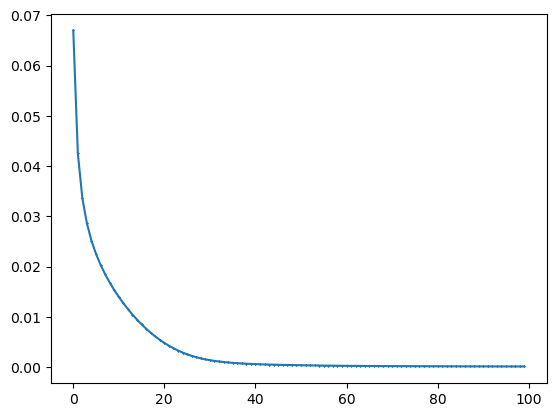

In [55]:
plt.plot(loss_vals, marker = 'x', markersize=1, markerfacecolor = 'r')

In [56]:
(np.sqrt(loss_vals[0])/(abs(target_torch).mean()))*100

tensor(193.3698)

In [57]:
(np.sqrt(loss_vals[-1])/(abs(target_torch).mean()))*100

tensor(8.3182)

In [58]:
source_torch.shape, target_torch.shape, output_torch.shape

(torch.Size([1, 242, 300]),
 torch.Size([1, 242, 300]),
 torch.Size([1, 242, 300]))

In [59]:
def denormalize_global(array, min_val=-5.049882127052023, max_val=6.446737822522641):
    if max_val == min_val:
        return np.zeros_like(array)
    return (array + 1) * (max_val - min_val) / 2 + min_val

In [60]:
def convert_to_axis_angle(data):
    '''data [T, 242]'''
    axis_magnitude = data[:, 6:226].reshape(-1, 55, 4)
    axis = axis_magnitude[:, :, :3]
    magnitude = axis_magnitude[:, :, 3:]
    poses = axis * (magnitude+1e-10)
    poses = poses.reshape(axis_magnitude.shape[0], -1)
    new_data = torch.cat([data[:, :6], poses, data[:, 226:]], axis=1)
    return new_data

In [61]:
source_un_norm = denormalize_global(source_torch.permute(0, 2, 1))
source_un_norm_axis_angle = torch.stack([convert_to_axis_angle(point) for point in source_un_norm])

In [62]:
target_un_norm = denormalize_global(target_torch.permute(0, 2, 1))
target_un_norm_axis_angle = torch.stack([convert_to_axis_angle(point) for point in target_un_norm])

In [63]:
output_un_norm = denormalize_global(output_torch.permute(0, 2, 1))
output_un_norm_axis_angle = torch.stack([convert_to_axis_angle(point) for point in output_un_norm])

In [64]:
source_un_norm_axis_angle.shape, target_un_norm_axis_angle.shape, output_un_norm_axis_angle.shape

(torch.Size([1, 300, 187]),
 torch.Size([1, 300, 187]),
 torch.Size([1, 300, 187]))

In [65]:
path = '/home/arunreddy/ML/Social-Robots/Code/Duolando-main/animations_test/'

In [66]:
vis_results(source_un_norm_axis_angle, target_un_norm_axis_angle, output_un_norm_axis_angle, 89, path, is_smplx=True)

Plotting at epoch 89


100%|██████████| 1/1 [03:35<00:00, 215.66s/it]


In [67]:
abs(output_un_norm_axis_angle[0][100] - output_un_norm_axis_angle[0][1]).mean()

tensor(0.2007, grad_fn=<MeanBackward0>)

In [68]:
abs(target_un_norm_axis_angle[0][100] - target_un_norm_axis_angle[0][1]).mean()

tensor(0.1732)